In [1]:
#!pip install powerlaw
import pandas as pd
import glob
import numpy as np
import pickle
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw
import math
import operator

In [15]:
with open(r"cleaned_data\unique_users", 'rb') as file:
    unique_users = pickle.load(file)

with open(r"cleaned_data\user_net_submissions", 'rb') as file:
    submissions = pickle.load(file)

with open(r"cleaned_data\user_net_comments", 'rb') as file:
    comments = pickle.load(file)

In [122]:
#Graph creation

G = nx.MultiDiGraph()
G.add_nodes_from(set(unique_users))
print(len(G.nodes))

152730


In [17]:
print(comments)
print(submissions)

           index       id           author link_id parent_id
25            34  c02s9t4  LiberalDemocrat   648os     648os
55            72  c02s9u6        DiscoWolf   648os     648os
63            83  c02s9uh         Flemlord   648p5     648p5
69            89  c02s9un  LiberalDemocrat   648oy     648oy
72            94  c02s9us  LiberalDemocrat   648p5     648p5
...          ...      ...              ...     ...       ...
4873684  7242866  c064gsy     rhythmicidea   7amdg   c064gqo
4873685  7242867  c064gsz   blackwhitegrey   7ajij     7ajij
4873686  7242868  c064gt0       Drewster58   7amg7     7amg7
4873687  7242869  c064gt1           eerock   7akoc     7akoc
4873688  7242870  c064gt2           mycall   7ajjm     7ajjm

[3781518 rows x 5 columns]
            id         author
0        648oo          DITUS
1        648op         rmuser
3        648or          zorno
4        648os         rmuser
6        648ou  anteeknetshop
...        ...            ...
2519831  7amfx      oddietaco


In [18]:
#Sort data

comments = comments.sort_values(by='link_id', ascending=False)
print(comments)
submissions = submissions.sort_values(by='id', ascending = False)
print(submissions)

           index       id      author link_id parent_id
1386311  2052819     7v8c  julenissen   7mq30     7mq30
1386252  2052738     7v61  catlebrity   7mq2q     7mq2q
1386322  2052839     7v8w       stumo   7mq1x     7mq1x
1386337  2052865     7v9m       eMigo   7mq1x     7mq1x
1386256  2052742     7v65  russianout   7mq1r     7mq1r
...          ...      ...         ...     ...       ...
139          170  c02s9ww   reflibman   648or     648or
2685        3784  c02scpa   sexydarin   648op     648op
2543        3608  c02scke     quiller   648op     648op
579          766  c02sadg     fotoman   648op     648op
6055        8511  c02sgcn   Gargilius   648op     648op

[3781518 rows x 5 columns]
           id         author
846563  7mq3v         klippa
846559  7mq3r       middkidd
846558  7mq3q       bixiebix
846551  7mq3j   ohstrangeone
846550  7mq3h      shadowvox
...       ...            ...
6       648ou  anteeknetshop
4       648os         rmuser
3       648or          zorno
1       64

In [23]:
#Divide data

mask = comments['link_id'] == comments['parent_id']
comments_on_submissions = comments[mask]
comments_on_comments_mask = ~mask
comments_on_comments = comments[comments_on_comments_mask]

print(comments_on_submissions)
print(comments_on_comments)

           index       id      author link_id parent_id
1386311  2052819     7v8c  julenissen   7mq30     7mq30
1386252  2052738     7v61  catlebrity   7mq2q     7mq2q
1386322  2052839     7v8w       stumo   7mq1x     7mq1x
1386337  2052865     7v9m       eMigo   7mq1x     7mq1x
1386256  2052742     7v65  russianout   7mq1r     7mq1r
...          ...      ...         ...     ...       ...
139          170  c02s9ww   reflibman   648or     648or
2685        3784  c02scpa   sexydarin   648op     648op
2543        3608  c02scke     quiller   648op     648op
579          766  c02sadg     fotoman   648op     648op
6055        8511  c02sgcn   Gargilius   648op     648op

[1475742 rows x 5 columns]
           index       id           author link_id parent_id
1386248  2052730     7v5t   LapsedPacifist   7mq1o      7v47
1386225  2052690     7v4p         The_Yeti   7mpwf      7ujp
1385832  2052096     7uo3      SnowLeopard   7mpwf      7ug0
1386019  2052395     7uwg      SnowLeopard   7mpwf      

In [123]:
def generate_edge(x,y):
    if x != y:
        if (x, y, x) in G.edges:  
            old_weight = G.get_edge_data(x, y, key=x)['weight']
            new_weight = old_weight + 1
            G.add_edge(x, y, key = x, weight=new_weight)
        else:
            G.add_edge(x, y, key = x, weight=1)

In [30]:
submissions = submissions.reset_index()
print(submissions)

         index     id         author
0       846563  7mq3v         klippa
1       846559  7mq3r       middkidd
2       846558  7mq3q       bixiebix
3       846551  7mq3j   ohstrangeone
4       846550  7mq3h      shadowvox
...        ...    ...            ...
797902       6  648ou  anteeknetshop
797903       4  648os         rmuser
797904       3  648or          zorno
797905       1  648op         rmuser
797906       0  648oo          DITUS

[797907 rows x 3 columns]


In [124]:
#Add edges from comments_on_submissions

comments_on_submissions.reset_index()
curr_submissions_index = 0
cur_submissions_id = submissions.iat[curr_submissions_index, submissions.columns.get_loc('id')]
for _,_,_,author,link_id,_ in comments_on_submissions.itertuples():
    while link_id != cur_submissions_id:
            curr_submissions_index+=1
            cur_submissions_id = submissions.iat[curr_submissions_index, submissions.columns.get_loc('id')]
    curr_submissions_author = submissions.iat[curr_submissions_index, submissions.columns.get_loc('author')]
    generate_edge(author,curr_submissions_author)

In [117]:
#Create dictionary with key,value pairs (comment_id, author)

dict2 = dict(zip(comments_on_comments['id'], comments_on_comments['author']))

In [126]:
#Add edges from comments_on_comments

comments_on_comments.reset_index()
for _,_,_,author,link_id, parent_id in comments_on_comments.itertuples():
    if parent_id in dict2: 
        comment_author = dict2[parent_id]
        generate_edge(author, comment_author)

In [130]:
#Save UserNet

nx.info(G)

output_path = "models/UserNet.gml"
nx.write_gml(G, output_path)

In [6]:
G = nx.read_gml("models/UserNet.gml")

In [7]:
nodesToRemove = list(nx.isolates(G))
G.remove_nodes_from(nodesToRemove)
print(len(list(G.nodes)))
output_path = "models/UserNetFiltered.gml"
nx.write_gml(G, output_path)

76038


In [8]:
#Network density

number_of_edges = G.number_of_edges()
number_of_nodes = G.number_of_nodes()

absolut_number_of_edges = number_of_nodes * (number_of_nodes - 1)
network_density = number_of_edges/absolut_number_of_edges

print("Network density is: ",network_density)

Network density is:  0.0003412358856776285


In [154]:
#Find strongly connected components

S = [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
largest_component = S[0]
print("Number of components : ", len(S))
print("Number of nodes in largest component : ", largest_component.number_of_nodes())

Number of components :  39211
Number of nodes in largest component :  36746


In [153]:
#Find weakly connected components

S = [G.subgraph(c).copy() for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]
largest_weakly_connected_component = S[0]
print("Number of components : ", len(S))
print("Number of nodes in largest component : ", largest_component.number_of_nodes())

Number of components :  639
Number of nodes in largest component :  74469


In [193]:
#Save the largest component

output_path = "models/UserNetLargestComponent.gml"
nx.write_gml(largest_component, output_path)

In [9]:
G = nx.read_gml("models/UserNetLargestComponent.gml")

In [ ]:
#3.8 Diameter and Average shortest path - did not manage to run approximation
import networkx as nx
from networkx.algorithms import approximation
import networkx as nx

diameter_value = approximation.diameter(largest_component)
print("UserNet diameter: ", diameter_value)

In [ ]:
average_shortest_path_length = nx.average_shortest_path_length(largest_component, weight='weight') 
print("Average shortest path length with weight: ", average_shortest_path_length)
average_shortest_path_length = nx.average_shortest_path_length(largest_component) 
print("Average shortest path length without weight: ", average_shortest_path_length)
# NetworkXError: Graph is not weakly connected.

In [ ]:
average_clustering_coefficient = nx.average_clustering(G)
global_clustering_coefficient = nx.transitivity(G)

In [ ]:
# -> From Gephi
#Diameter: 10
#Radius: 5
#Average Path length: 3.20275654675197

In [11]:
#3.12
r1 = nx.degree_assortativity_coefficient(G)
print("Assortativity coefficient for non weighted graph: ", r1)

Assortativity coefficient for non weighted graph:  -0.04617843740220365


In [3]:
#3.14 Degree distribution

def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)        
    #print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(0, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

C:\Users\sretenp\AppData\Local\Temp/ipykernel_9668/2804442282.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, max(y))


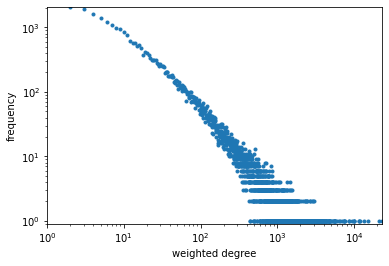

In [4]:
plot_deg_frequency(G, weighted = True)

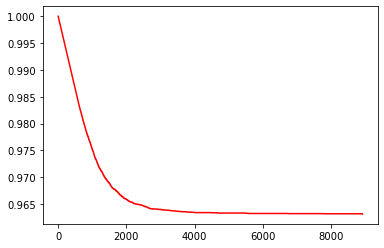

In [12]:
# Power law distribution

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

max_deg = max(deg)

values, base = np.histogram(deg, bins = max_deg)

# Cumulative sum (Inclusive prefix sum)
cumulative = np.cumsum(values)

# Ploting of complementary cumulative node degree distribution P(X>x)
plt.plot(base[:-1], [float(x)/len(G) for x in len(G) - cumulative], c='red')

plt.show()

In [6]:
results = powerlaw.Fit(degree_sequence)
print(results.supported_distributions)

print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
R, p = results.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'exponential')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'truncated_power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")


Calculating best minimal value for power law fit
{'power_law': <class 'powerlaw.Power_Law'>, 'lognormal': <class 'powerlaw.Lognormal'>, 'exponential': <class 'powerlaw.Exponential'>, 'truncated_power_law': <class 'powerlaw.Truncated_Power_Law'>, 'stretched_exponential': <class 'powerlaw.Stretched_Exponential'>, 'lognormal_positive': <class 'powerlaw.Lognormal_Positive'>}
3.357462027654507
952.0
0.0967278386370514
Loglikelihood ratio: -5.712881026750495
Statistical significance: 0.05685111617221731
Loglikelihood ratio: 11.465023677211054
Statistical significance: 0.2800587338612248


Assuming nested distributions


Loglikelihood ratio: -5.670994538105182
Statistical significance: 0.0007577412134861516


In [13]:
#3.15 Hubs and authorities

hubs, authorities =nx.hits(G)

hub_items = sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("UserNet Hubs\n")
for hub_item in hub_items:
    print(hub_item)

authority_items = sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("\nUserNet Authorities\n")
for authority_item in authority_items:
    print(authority_item)

UserNet Hubs

('malcontent', 0.0031086961824934997)
('NoMoreNicksLeft', 0.0030286784011830034)
('matts2', 0.002825724475116414)
('cartooncorpse', 0.0022816071295664125)
('randomb0y', 0.0020466802453137757)
('eleitl', 0.0020235375315977595)
('alllie', 0.0019269023821792506)
('RugerRedhawk', 0.001812345666351941)
('sakebomb69', 0.001800023338738594)
('mutatron', 0.0017505951369599516)

UserNet Authorities

('qgyh2', 0.010139825986875883)
('rmuser', 0.00990534361316391)
('alllie', 0.005872691355346865)
('maxwellhill', 0.004809302066666243)
('noname99', 0.004771453664315664)
('georgewashingtonblog', 0.004618163353814055)
('twolf1', 0.004599607910239071)
('IAmperfectlyCalm', 0.004216141682750718)
('gst', 0.004046468235431592)
('matts2', 0.003929323138609022)


In [3]:
print("Top 10 Out Degree centrality:\n")
Out_DC = nx.out_degree_centrality(G)
dc_items = sorted(Out_DC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for dc_item in dc_items:
    print(dc_item[0], "\t\t",dc_item[1], "\t",G.degree[dc_item[0]])

Top 10 Out Degree centrality:

NoMoreNicksLeft 		 0.07709892502381277 	 4657
randomb0y 		 0.06324670023132399 	 3588
mutatron 		 0.060552456116478436 	 3330
malcontent 		 0.0589740100693972 	 3740
h0dg3s 		 0.05870186419921078 	 3436
Poromenos 		 0.057586066131446456 	 3761
7oby 		 0.0570962035651109 	 5466
mexicodoug 		 0.056198122193495716 	 3468
nixonrichard 		 0.05451081779833991 	 3988
otakucode 		 0.05380323853585522 	 3604


In [5]:
print("Top 10 In Degree centrality:\n")
IN_DC = nx.in_degree_centrality(G)
dc_items = sorted(IN_DC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for dc_item in dc_items:
    print(dc_item[0], "\t\t",dc_item[1], "\t",G.degree[dc_item[0]])

Top 10 In Degree centrality:

rmuser 		 0.21385222479248878 	 8910
qgyh2 		 0.1922166281126684 	 7783
noname99 		 0.14875493264389714 	 5568
alllie 		 0.13468499115525923 	 6740
swampsparrow 		 0.13133759695196626 	 5515
gst 		 0.12703769220302083 	 4670
maxwellhill 		 0.12129541434208736 	 4475
twolf1 		 0.10725268744046809 	 4007
georgewashingtonblog 		 0.10085725949108722 	 3904
7oby 		 0.09165872907878624 	 5466


In [ ]:
#3.16 
    
print("\nTop 10 Closeness centrality:\n")
CC = nx.closeness_centrality(G)
cc_items = sorted(CC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for cc_item in cc_items:
    node = cc_item[0]
    print(cc_item[0], "   ", cc_item[1])

# Not implemented for multigraph type
print("\nTop 10 Betweenness centrality:\n")
BC = nx.betweenness_centrality(G)
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for bc_item in bc_items:
    node = bc_item[0];
    print(bc_item[0], "   ", bc_item[1])
    
# Not implemented for multigraph type
print("\nTop 10 Betweenness centrality with weight:\n")
BC = nx.betweenness_centrality(G, weight='weight')
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for bc_item in bc_items:
    node = bc_item[0];
    print(bc_item[0], "   ", bc_item[1])

In [ ]:
#1.17 Eigenvector centrality - Not implemented for multigraph type

print("\nTop 10 Eigenvector centrality:\n")
EC = nx.eigenvector_centrality(G)
ec_items = sorted(EC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for ec_item in ec_items:
    print(ec_item[0], "   ", ec_item[1])

In [ ]:
lambda_max =  max(nx.adjacency_spectrum(G))
print(1/lambda_max)

In [ ]:
KC = nx.katz_centrality(G, alpha=1/(2*lambda_max), beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight=None)
kc_items = sorted(KC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for kc_item in kc_items:
    print(kc_item[0], "   ", kc_item[1])